# Driftscan FFI analysis -- `astrometry.net` batch process

Michael Gully-Santiago  
June 28, 2018

This notebook follows a tutorial from [sep](http://sep.readthedocs.io/), maintained by Kyle Barbary.

The goal of this notebook is to find out where Kepler was pointing during the driftscans.

In [1]:
import numpy as np
import sep
import pandas as pd

In [2]:
# additional setup for reading the test image and displaying plots
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

We'll add some custom tools:

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../code/"))
import ffi_tools

I have the data saved locally for now.  Kepler channels have four distinct orientations on the sky (separated by 90$^\circ$ rotations from each other.  For example, in [FFI images](https://keplerscience.arc.nasa.gov/images/release-notes/c6/spica.png) you can see that certain saturated stars have their bleed columns pointing in orthogonal directions-- some go up, and some go down.  Some are also "upside down" relative to others.


For simplicity let's just focus on channels possessing the same orientation.  Thankfully, Christina Hedges identified these already!

In [4]:
ch_set_I = np.array([13,33,53,37,57,41,27,31,47,51,71])
ch = ch_set_I[2]

In [5]:
#! ls -1 ../data/C17_driftscans/ffi-kacr2120/kplr*.fits

In [6]:
dffis = ['../data/C17_driftscans/ffi-kacr2120/kplr2018131024020_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131032646_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131041344_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131094047_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131130639_ffi-orig.fits']

## Object detection

We will need a kernel for object detection.

In [7]:
kernel = ffi_tools.get_kernel()
ny, nx = kernel.shape

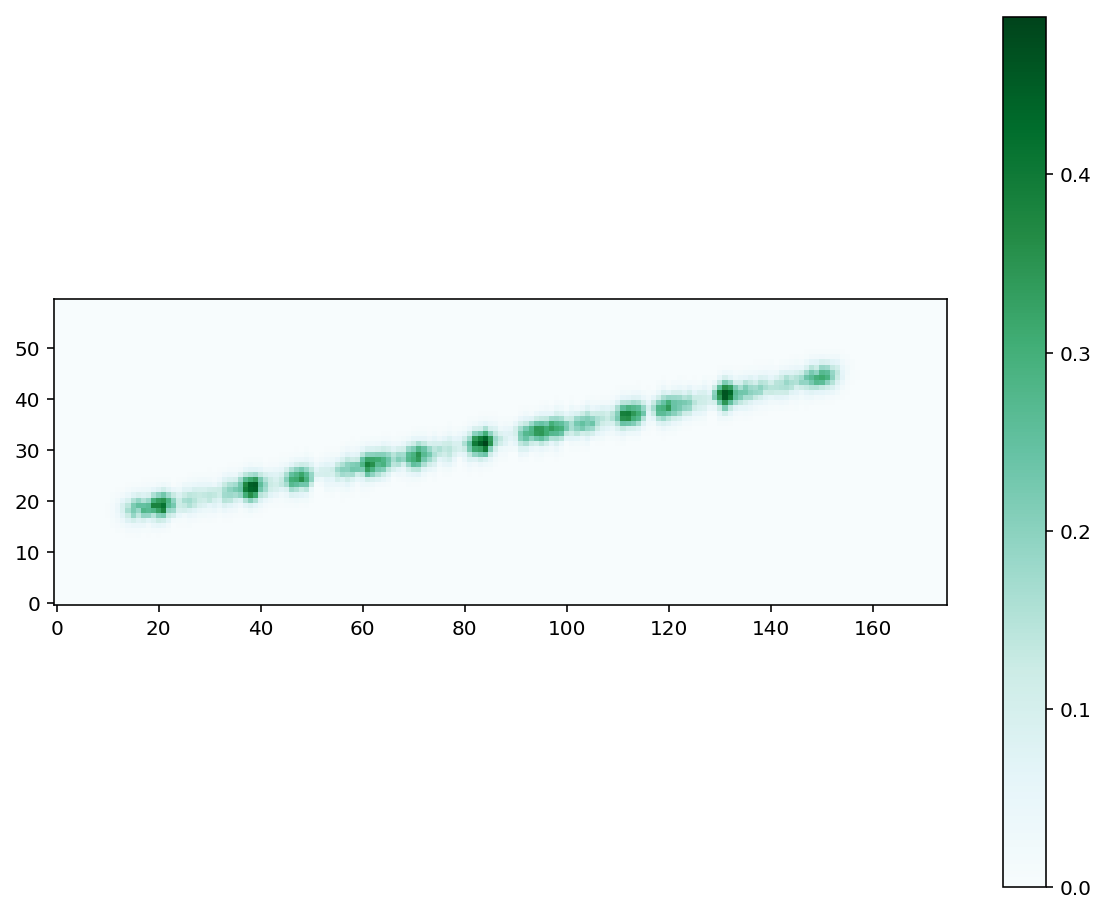

In [36]:
ffi_tools.plot_kernel(kernel)

### Batch source extraction with the kernel.

In [9]:
from astropy.utils.console import ProgressBar

A Jupyter Widget

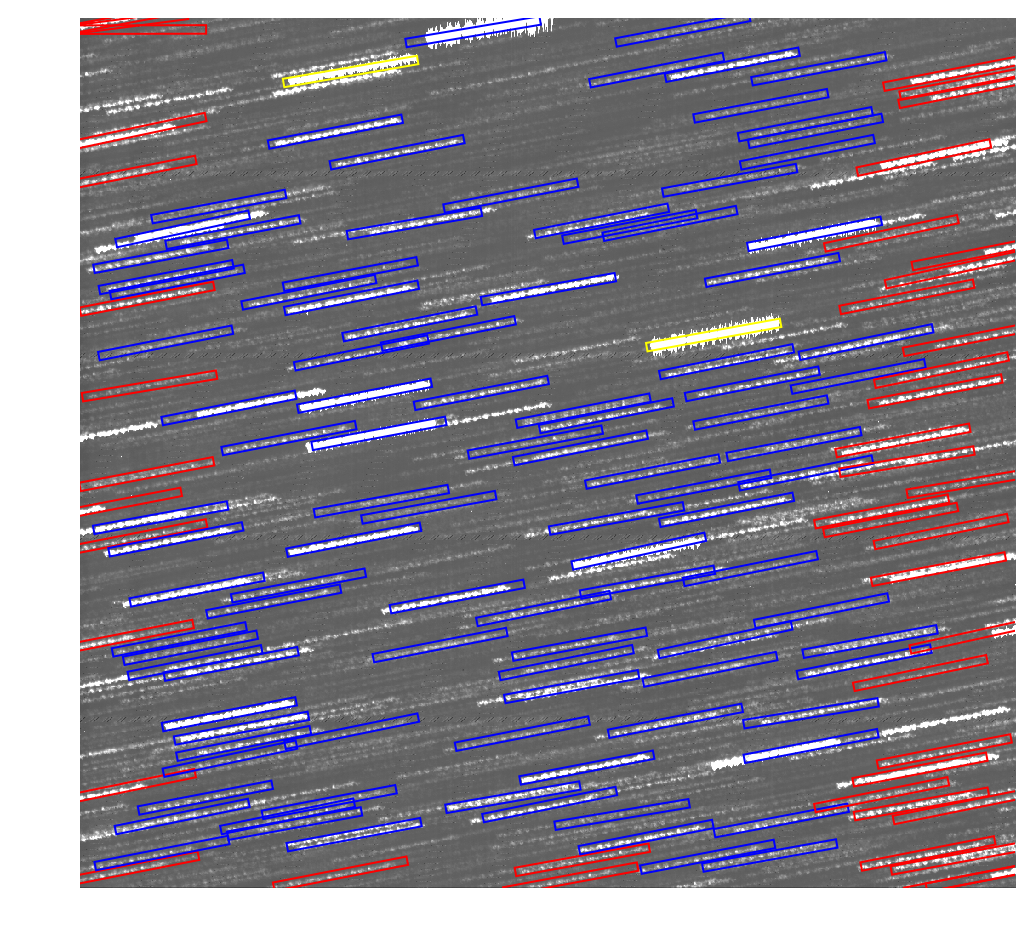

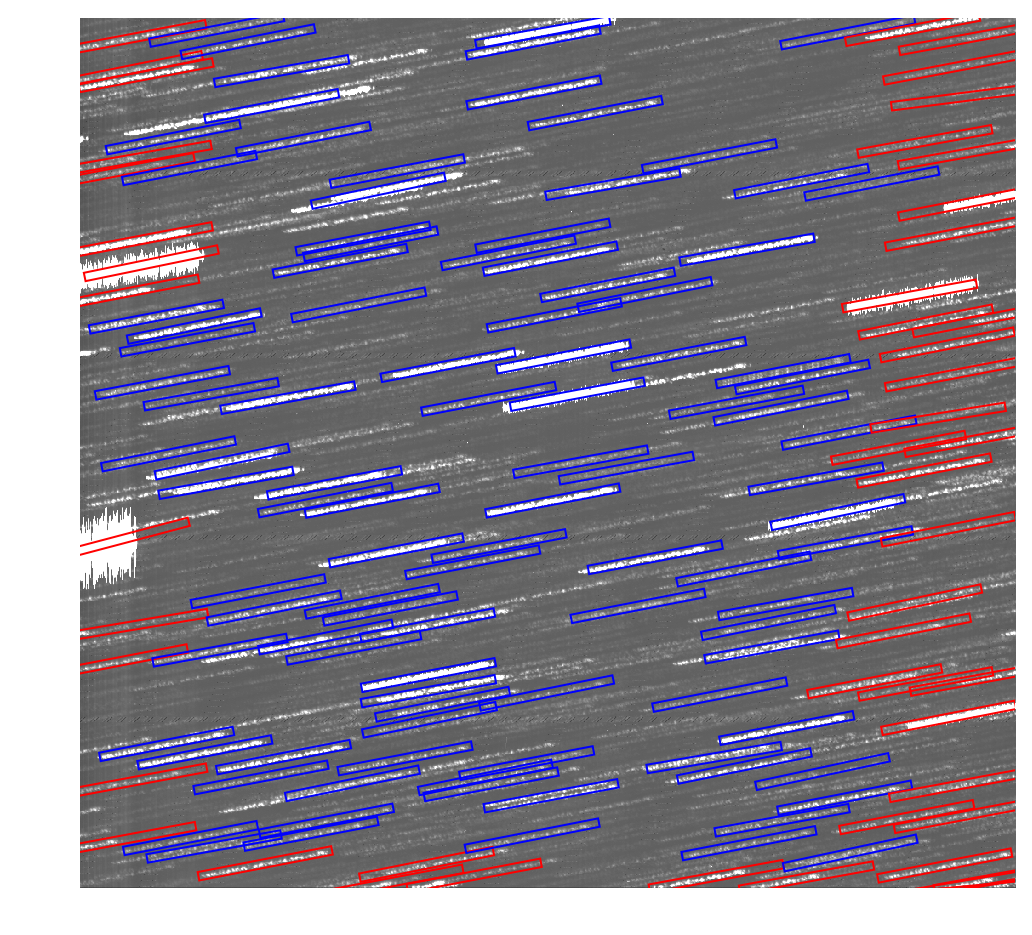

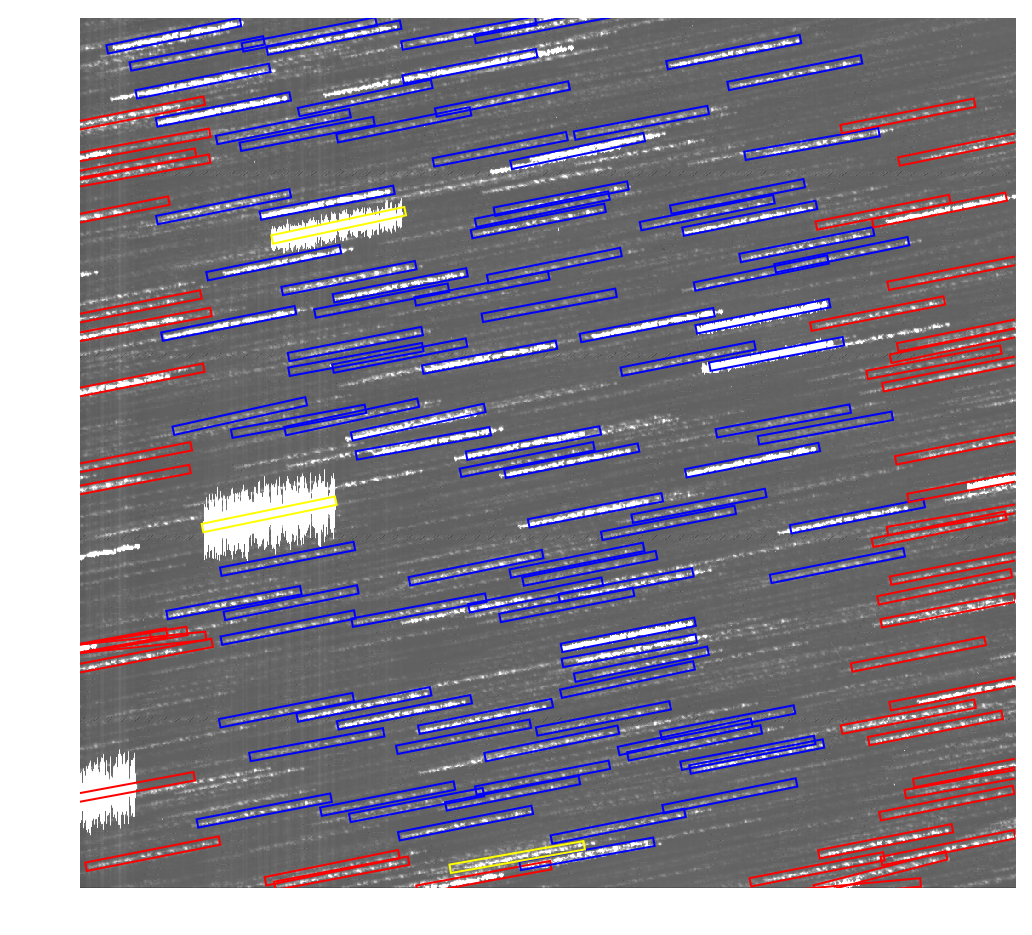

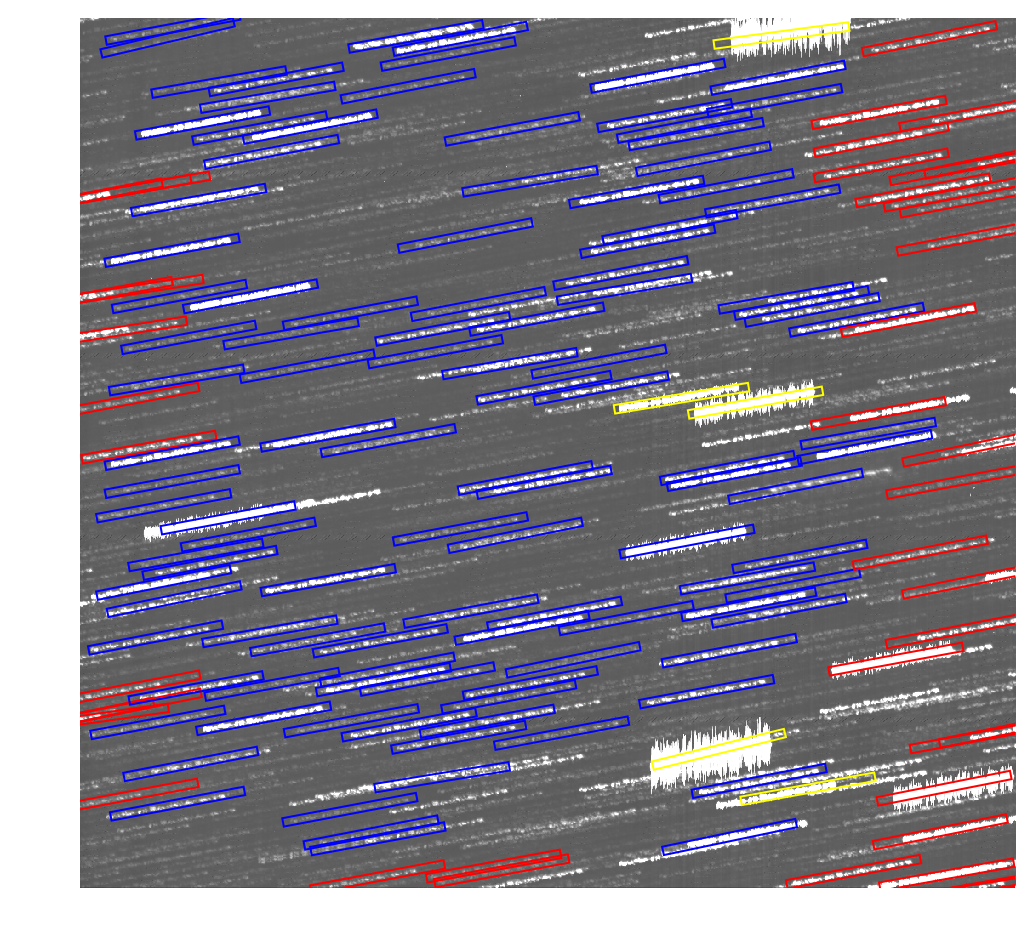

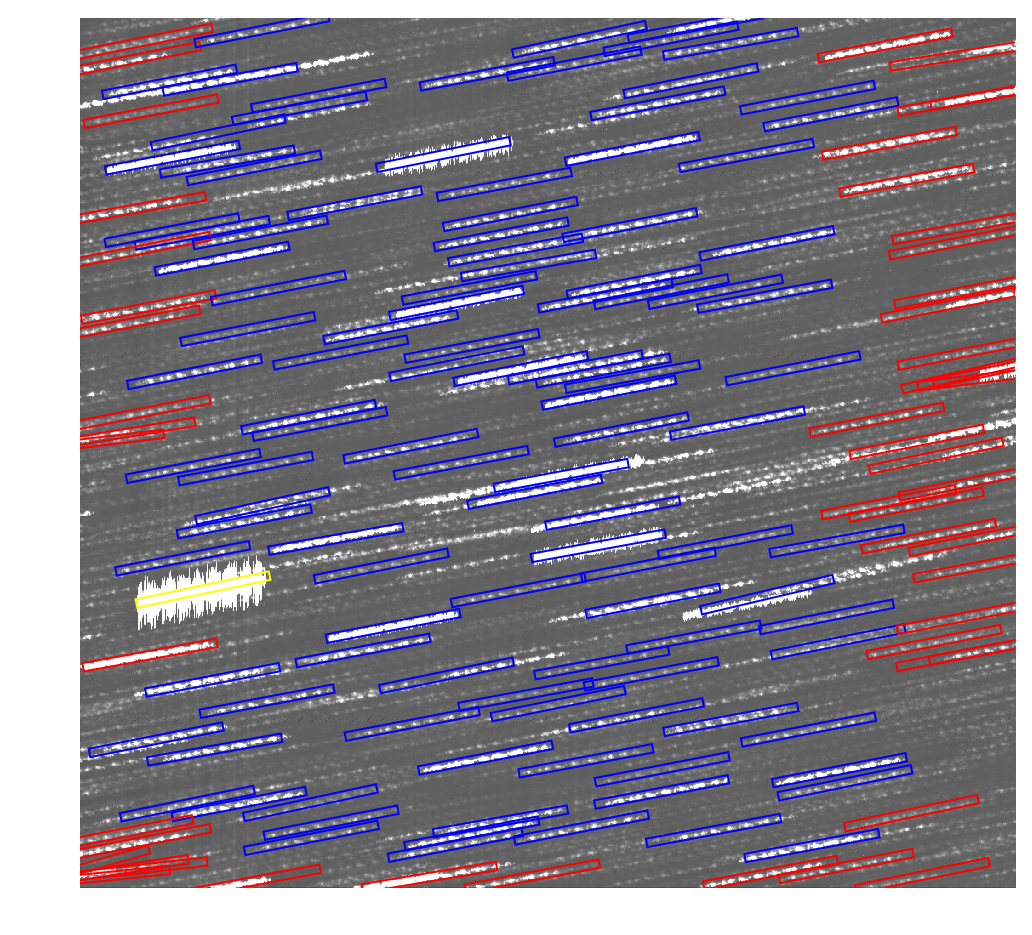

In [10]:
df_all = pd.DataFrame()

with ProgressBar(len(dffis)*11, ipython_widget=True) as bar:
    for dffi_num, dffi_fn in enumerate(dffis):
        for ch in ch_set_I:
            data, hdr0 = fitsio.read(dffi_fn, ext=ch, header=True)

            data = ffi_tools.preprocess_dFFI(data) 
            sx, sy = data.shape

            data_sub, bkg = ffi_tools.background_subtract(data, return_bkg=True)

            objects = sep.extract(data_sub, 4.0, filter_kernel=kernel,  err=bkg.globalrms)

            poor_fits = ( ((objects['theta']* 180. / np.pi) > 20) |
                          (objects['b'] > 15.0) |
                          (objects['x'] < (nx/2 + 2)) | 
                          (objects['x'] > ( sx - nx/2 - 2)) |
                          (objects['y'] < (ny/2 + 2)) |  
                          (objects['y'] > ( sy - ny/2 - 2)) )

            saturated_mask = (objects['b'] > 5.0) & ~poor_fits

            df_objects = pd.DataFrame(objects)
            df_objects['poor_fit'] = poor_fits
            df_objects['saturated'] = saturated_mask

            df_objects['ffi_num'] = dffi_num
            df_objects['ch_num'] = ch
            df_all = df_all.append(df_objects, ignore_index=True)
            if ch == 13:
                ffi_tools.plot_extractions(data_sub, df_objects)
            bar.update()

In [11]:
df_all.shape

(7931, 34)

In [12]:
gi = ~df_all.poor_fit & ~df_all.saturated
df_cln = df_all[gi].reset_index(drop=True)

Make a star kernel.

In [13]:
from scipy.stats import multivariate_normal

In [14]:
m, s = np.mean(data_sub), np.std(data_sub)
dw = 10

In [15]:
x, y = np.mgrid[-dw:dw:1, -dw:dw:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([0.0, 0.0], [[2.0, 0.3], [0.3, 2.2]])
star_kernel = rv.pdf(pos)  #plt.contourf(x, y, star_kernel)

In [28]:
"{:02d}".format(3)

'03'

In [ ]:
from astropy.io import fits

In [33]:
for dffi_num, dffi_fn in enumerate(dffis):
    for ch in ch_set_I:

        synthetic_data = data_sub*0.0
        df_sing = df_cln[(df_cln.ch_num ==ch) & (df_cln.ffi_num == dffi_num)].reset_index(drop=True)
        for i in range(len(df_sing)):
            try:
                xc, yc, flx = int(df_sing.y[i]), int(df_sing.x[i]), df_sing.flux[i]
                synthetic_data[xc-dw:xc+dw, yc-dw:yc+dw] = star_kernel*flx
            except:
                pass

        fits.writeto('../data/reverse_engineered/ch{:02d}_ffi{:02d}_rev_eng.fits'.format(ch, dffi_num),
                     synthetic_data, overwrite=True)

In [35]:
! open ../data/